---
title: "Анализ и оптимизация ассортиментной матрицы крупного онлайн-маркетплейса"
subtitle: "В рамках проекта была проведена детальная аналитика данных о продажах крупного онлайн-маркетплейса. С использованием Python и Jupyter Notebook были выполнены следующие шаги: сбор и подготовка данных, проведение статистического анализа, визуализация результатов и формирование рекомендаций по оптимизации ассортиментной матрицы. В результате были выявлены ключевые закономерности в продажах, предложены меры по увеличению количества продаж, выводу низкопродаваемых товаров из ассортимента и повышению маржинальности."
author: Ekaterina
echo: False
format:
    pdf:
        documentclass: report
        mainfont: "Times New Roman"
        code-fold: true
keep-inpynb: true
---

In [61]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
from pandas import DataFrame
import plotly.io as pio
import matplotlib.pyplot as plt
from IPython.display import Markdown
import gdown

pio.templates.default = "plotly_white"

In [62]:
url = 'https://drive.google.com/file/d/1aTq3ZGa7nn7cqmUV724lbZ-5ieBG9QTt/view?usp=sharing'
output = 'online_marketplace_sales.csv'
gdown.download(url, output, quiet=False, fuzzy=True)
df = pd.read_csv(output, parse_dates=["purchase_datetime"])

Downloading...
From (original): https://drive.google.com/uc?id=1aTq3ZGa7nn7cqmUV724lbZ-5ieBG9QTt
From (redirected): https://drive.google.com/uc?id=1aTq3ZGa7nn7cqmUV724lbZ-5ieBG9QTt&confirm=t&uuid=d27fc9ef-5b3c-4b88-80ad-6909016d4def
To: D:\SynologyDrive\Ekaterina\My\Python\personal\online_marketplace_sales\analytics\online_marketplace_sales.csv
100%|██████████| 143M/143M [00:19<00:00, 7.18MB/s] 


## Анализ продаж

В условиях динамично меняющегося рынка и высокой конкуренции, оптимизация ассортиментной матрицы является ключевым фактором для успешного бизнеса. Ассортиментная матрица включает в себя широкий спектр товаров, каждый из которых имеет свои особенности и характеристики. Эффективное управление ассортиментом позволяет не только увеличить объем продаж, но и повысить маржинальность, а также удовлетворить потребности различных сегментов клиентов.

**Цель данного анализа** — провести детальный обзор текущего состояния ассортиментной матрицы, выявить ключевые товары, которые приносят наибольшую выручку и объем продаж, а также определить товары, требующие внимания или возможного вывода из ассортимента. Для этого будет проведен **ABC-анализ**, который классифицирует товары на три категории: **A (основные), B (вторичные) и C (незначительные)** по двум ключевым показателям — количеству продаж и выручке.

**ABC-анализ** является мощным инструментом для управления ассортиментом, позволяя сфокусироваться на наиболее важных товарах и принять обоснованные решения по их продвижению, оптимизации и, при необходимости, выводу из ассортимента. В результате анализа будут предложены конкретные рекомендации по увеличению объема продаж, повышению маржинальности и улучшению общей эффективности ассортиментной матрицы.

In [63]:

def perform_abc(df:DataFrame, index:str) -> DataFrame:
    """
    :param df: датафрейм
    :param index: название столбца по которому выполняем группировку 
    :return: abc анализ
    """
    # Убираем столбец группировки
    cols = (list(df.columns))  # Получаем список всех столбцов DataFrame
    cols.remove(index)  # Удаляем из списка столбец, который используется для группировки

    # Производим суммирование по остальным столбцам с использованием dict comprehension
    groupped_df = df.groupby(index).agg({col: 'sum' for col in cols})  # Группируем DataFrame по столбцу index и суммируем значения по остальным столбцам

    for col in cols:
        # Вычисляем относительные значения для каждого столбца
        groupped_df[f'rel_{col}'] = groupped_df[col] / sum(groupped_df[col])
        
        # Сортируем DataFrame по относительным значениям в порядке убывания
        groupped_df = groupped_df.sort_values(f'rel_{col}', ascending=False)
        
        # Вычисляем накопленные суммы для каждого столбца
        groupped_df[f'cumsum_{col}'] = groupped_df[f'rel_{col}'].cumsum()
        
        # Присваиваем категории A, B, C на основе накопленных сумм
        groupped_df[f'abc_{col}'] = np.where(groupped_df[f'cumsum_{col}'] < 0.8, 'A', np.where(groupped_df[f'cumsum_{col}'] < 0.95, 'B', 'C'))

    # Возвращаем DataFrame с исходными столбцами и новыми столбцами категорий
    return groupped_df[cols + [f'abc_{col}' for col in cols]]

In [64]:
df1 = df[['product_id', 'quantity', 'total_price']]

df_abc = perform_abc(df=df1, index='product_id')
df_abc

,quantity,total_price,abc_quantity,abc_total_price
product_id,,,,
37181,2348,126506926.0,A,A
30239,2121,122577085.0,A,A
22406,2119,122007891.0,A,A
10292,2202,121115031.0,A,A
45018,2235,118322228.0,A,A
...,...,...,...,...
35351,1261,4154.0,A,C
22981,1578,3960.0,A,C
25894,1884,1792.0,A,C


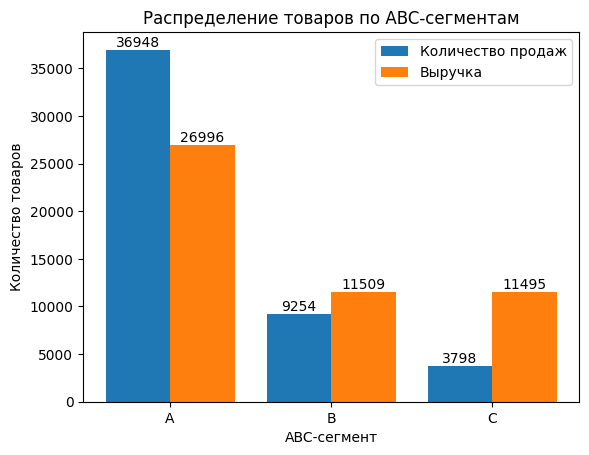

In [65]:
# Подсчет количества товаров по каждому ABC-сегменту
q_counts = df_abc['abc_quantity'].value_counts()
t_counts = df_abc['abc_total_price'].value_counts()

# Построение столбчатой диаграммы
fig, ax = plt.subplots()

bar_width = 0.4
x_labels = ['A', 'B', 'C']
x_positions = range(len(x_labels))

bars_q = ax.bar([x - bar_width/2 for x in x_positions], q_counts.reindex(x_labels, fill_value=0), width=bar_width, label="Количество продаж")
bars_t = ax.bar([x + bar_width/2 for x in x_positions], t_counts.reindex(x_labels, fill_value=0), width=bar_width, label="Выручка")

# Добавление подписей с количеством над столбцами
for bar in bars_q:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom', fontsize=10)
    
for bar in bars_t:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom', fontsize=10)

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)
ax.set_xlabel("ABC-сегмент")
ax.set_ylabel("Количество товаров")
ax.set_title("Распределение товаров по ABC-сегментам")
ax.legend()
plt.show()
plt.show()

## Группа AA (Высокая выручка и высокий объем продаж)
**Рекомендации:**

- **Поддержание текущих стратегий:** Необходимо поддерживать текущие маркетинговые и продажные стратегии для этих товаров.
- **Улучшение ассортимента:** Можно рассмотреть возможность улучшения ассортимента или добавления сопутствующих товаров для увеличения кросс-продаж. Например, если товар из группы AA часто покупается вместе с другим товаром, рассмотрите возможность размещения их рядом на полке или в одном рекламном блоке.
- **Лояльность клиентов:** Стоит попробовать ввести программы лояльности для клиентов, которые часто покупают эти товары, чтобы стимулировать повторные покупки. Например, предоставить скидку на последующую покупку или начисление бонусов

## Группа AC (Высокая выручка, но низкий объем продаж)
**Рекомендации:** Эта категория товаров приносит значительную выручку, но продаётся в небольших объемах. Возможно, речь идёт о премиальных или нишевых товарах с высокой ценой. Чтобы увеличить продажи, можно рассмотреть стратегии стимулирования спроса:

- **Развитие маркетинга** – усилить продвижение товаров, сделать акцент на их уникальных характеристиках и ценности.
- **Акции и специальные предложения** – например, добавить бонусы при покупке или предложить скидки на следующий заказ.
- **Работа с ассортиментом** – если товар ограничен в доступности, стоит рассмотреть расширение его присутствия, улучшение логистики или пересмотр ценообразования.

**Главная цель** – сохранить высокую выручку, но при этом найти способы увеличения количества проданных единиц без снижения маржинальности.

## Группа AB (Высокая выручка и средний объем продаж)
**Рекомендации:**

- **Акции и скидки:** Проведение акций и скидок поможет стимулировать увеличение объема продаж. Например, скидка 20% на товар, если он покупается в определенное время года или в рамках специальной акции.
- **Продвижение:** Стоит поработать над маркетинговым продвижение этих товаров, возможно, через социальные сети или email-рассылки. Например, вирусный рекламный ролик или пост в социальных сетях, который привлечет внимание к товару.
- **Специальные предложения:** Специальные предложения или пакеты для привлечения новых клиентов. Например, комплект из нескольких товаров по сниженной цене.

## Группа BA (Средняя выручка, но высокий объем продаж)
**Рекомендации:**

- **Анализ цен:** Следует провести анализ цен и рассмотрите возможность снижения цен для увеличения выручки.
- **Скидки и акции:** Проведение скидок и акций для стимулирования покупок этих товаров (см. выше). 
- **Продвижение:** Маркетинговое продвижение этих товаров, возможно, через социальные сети или email-рассылки (см. выше).

## Группа BB (Средняя выручка и средний объем продаж)
**Рекомендации:**
Рекомендации не отличаются от предложенных выше.

## Группа BC (Средняя выручка, но низкий объем продаж)
**Рекомендации:**
Эти товары приносят неплохую выручку, но продаются редко. Чтобы увеличить продажи, стоит привлечь больше внимания к данной категории. Можно провести акции и специальные предложения, стимулируя спрос. Если товары являются нишевыми или малоизвестными, рекомендуется усилить маркетинговую поддержку: разместить рекламу, подробно описать их преимущества и области применения, а также повысить узнаваемость среди целевой аудитории.

## Группа CA (Низкая выручка, но высокий объем продаж)
**Рекомендации:** Для этой категории товаров не требуется кардинальных изменений, поскольку они относятся к товарам первой необходимости, пользуются стабильным спросом и имеют невысокую стоимость. Однако можно рассмотреть стратегии повышения среднего чека, например, акции типа «Купите два, третий со скидкой». Дополнительно стоит провести анализ цен у конкурентов и оценить возможности оптимизации ценообразования, чтобы сохранить конкурентное преимущество и увеличить маржинальность.


## Группа CB (Низкая выручка, но средний объем продаж)
**Рекомендации:** Эта категория схожа с группой CA, однако здесь стоит уделить больше внимания возможностям увеличения выручки. Можно рассмотреть пересмотр ценовой политики, усиление маркетингового продвижения или внедрение специальных предложений, которые стимулируют спрос

## Группа CC (Низкая выручка и низкий объем продаж)
**Рекомендации:**

- **Анализ причин:** Чтобы понять причины низких продаж и выручки, необходимо провести анализ данных или собрать обратную связь от клиентов. Если товар не пользуется спросом, стоит рассмотреть варианты его улучшения — от изменения характеристик до обновления дизайна.
- **Снижение затрат:** Также необходимо изучить способы снижения затрат на производство и логистику. Если товар требует значительных вложений, оптимизация производственных процессов, может повысить его рентабельность.
- **Вывод из ассортимента:** Если товар не приносит выручки и не имеет перспектив для роста, стоит рассмотреть возможность его исключения из ассортимента. Важно оценить, можно ли улучшить его характеристики или маркетинговое продвижение, но если потенциала нет, лучше освободить место для более прибыльных позиций.

## Гипотеза

Можно предположить, что существует разница в покупательском поведении мужчин и женщин. Исторически женщины совершают больше покупок, но это требует статистического подтверждения.

Для проверки гипотезы необходимо разделить данные на группы **M** (мужчины) и **F** (женщины) и проанализировать их распределение.

Будет использоваться **Тест Колмогорова-Смирнова** и **Q-Q график** для оценки характера распределения. Исходя из полученных данных, будет выбран наиболее подходящий статистический метод для окончательной проверки гипотезы.

In [66]:
# Разделение данных на две группы: мужчины и женщины
male_data = df[df['gender'] == 'M']
female_data = df[df['gender'] == 'F']

In [67]:
# Тест Колмогорова-Смирнова для мужчин
ks_stat_male, ks_p_value_male = stats.kstest(male_data['quantity'], 'norm', args=(male_data['quantity'].mean(), male_data['quantity'].std()))
alpha = 0.05
if ks_p_value_male < alpha:
    male_message = "Распределение (Мужчин) значительно отличается от нормального"
else:
    male_message = "Нет достаточных оснований утверждать, что распределение отличается от нормального"
# Тест Колмогорова-Смирнова для женщин
ks_stat_female, ks_p_value_female = stats.kstest(female_data['quantity'], 'norm', args=(female_data['quantity'].mean(), female_data['quantity'].std()))
if ks_p_value_female < alpha:
    female_message = "Распределение (Женщин) значительно отличается от нормального"
else:
    female_message = "Нет достаточных оснований утверждать, что распределение отличается от нормального"

In [68]:
display(Markdown(male_message))
display(Markdown(female_message))

Распределение (Мужчин) значительно отличается от нормального

Распределение (Женщин) значительно отличается от нормального

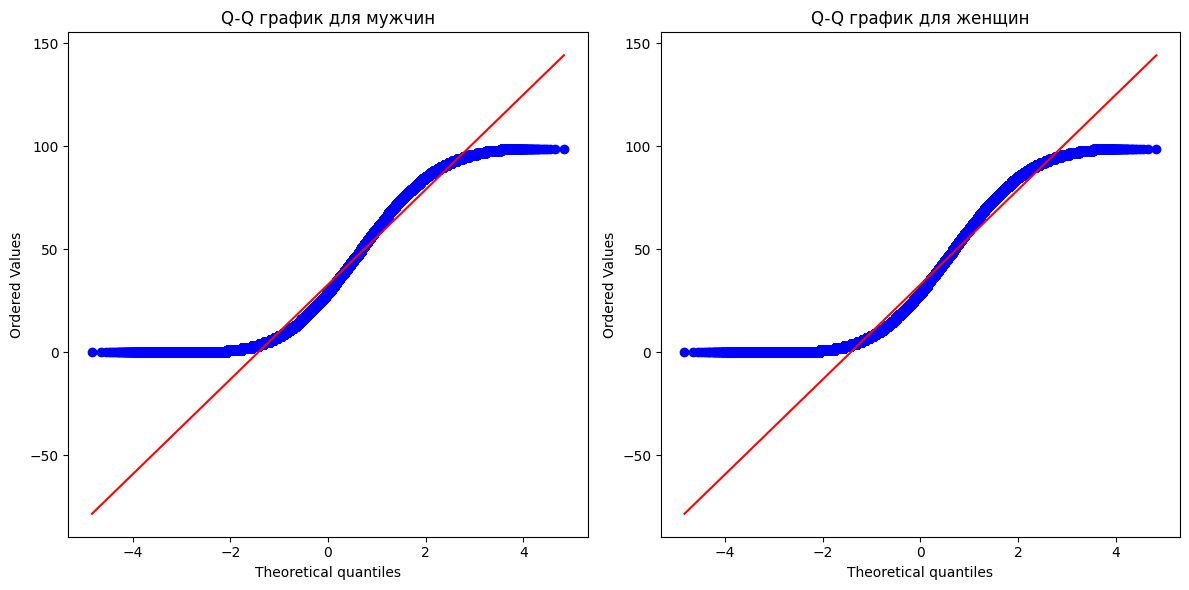

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Два графика в одном ряду

# Q-Q график для мужчин
stats.probplot(male_data['quantity'], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q график для мужчин')

# Q-Q график для женщин
stats.probplot(female_data['quantity'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q график для женщин')

plt.tight_layout()  # Улучшает расположение графиков
plt.show()

На основе графиков и статистических методов определения распределения данных можно сделать вывод, что данные распределены неравномерно. Поэтому для проверки гипотезы будет использоваться непараметрический метод – Манн-Уитни U-тест.

In [70]:
u_stat, p_value = mannwhitneyu(male_data['quantity'], female_data['quantity'], alternative='two-sided')
ms = f'U-статистика: {u_stat}, P-значение: {p_value}'

if p_value < 0.05:
    st = "Статистический анализ выявил значимые различия в среднем количестве покупок между мужчинами и женщинами."
else:
    st = "Статистический анализ не выявил значимые различия в среднем количестве покупок между мужчинами и женщинами."

In [71]:
display(Markdown(ms))
display(Markdown(st))

U-статистика: 520159666496.5, P-значение: 0.8509255010496187

Статистический анализ не выявил значимые различия в среднем количестве покупок между мужчинами и женщинами.